In [4]:
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt

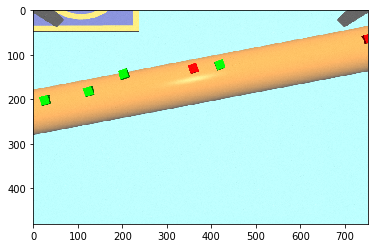

In [5]:
img = cv.imread("Sensor/img1.png")

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

In [3]:
tDroneWorld = np.array([3.0, -3.0, 1.0])
RDroneWorld = np.eye(3)

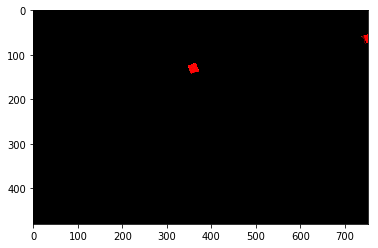

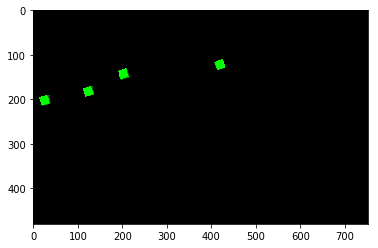

In [6]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

min_verm = np.array([0,210,100],np.uint8)
max_verm = np.array([8,255,255],np.uint8)
masc_verm = cv.inRange(hsv,min_verm,max_verm)
res_verm = cv.bitwise_and(img,img,mask= masc_verm)

min_verde = np.array([50,200,0],np.uint8)
max_verde = np.array([150,255,255],np.uint8)
masc_verde = cv.inRange(hsv,min_verde,max_verde)
res_verde = cv.bitwise_and(img,img,mask= masc_verde)

plt.imshow(cv.cvtColor(res_verm, cv.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv.cvtColor(res_verde, cv.COLOR_BGR2RGB))
plt.show()

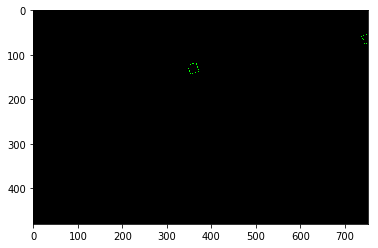

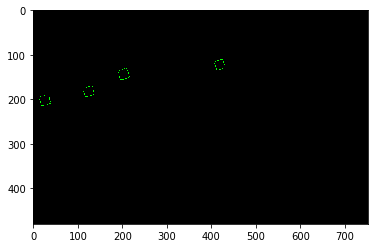

In [25]:
kernel = np.ones((5,5),np.uint8)

bordas = cv.Canny(masc_verm, 100, 500, kernel)
contoursVerm,hierarchyVerm = cv.findContours(bordas, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

imgContVerm = cv.drawContours(np.zeros_like(img), contoursVerm, -1, (0,255,0), 1)


bordas = cv.Canny(masc_verde, 100, 500, kernel)
contoursVerde,hierarchyVerm = cv.findContours(bordas, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

imgContVerde = cv.drawContours(np.zeros_like(img), contoursVerde, -1, (0,255,0), 1)

plt.imshow(imgContVerm)
plt.show()

plt.imshow(imgContVerde)
plt.show()

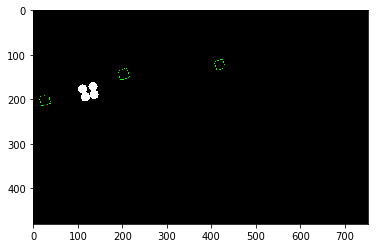

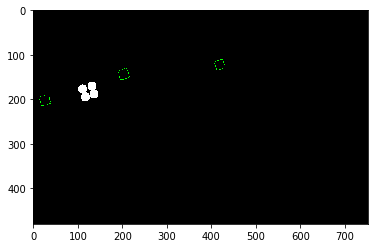

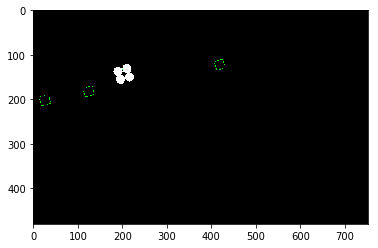

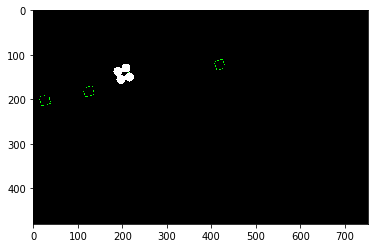

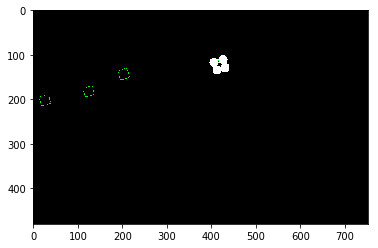

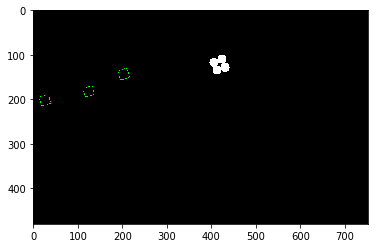

In [70]:

for i in range(len(contoursVerde)):
    epsilon = 0.1*cv.arcLength(contoursVerde[i],True)
    approx = cv.approxPolyDP(contoursVerde[i],epsilon,True)

    img = imgContVerde.copy()

    if(len(approx) < 4):
        continue

    if not cv.isContourConvex(approx):
            continue

    for point in approx:
        cv.circle(img, (point[0][0], point[0][1]), 10, (255,255,255), -1)

    plt.imshow(img)
    plt.show()

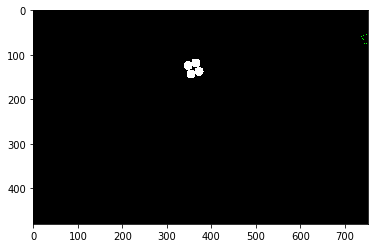

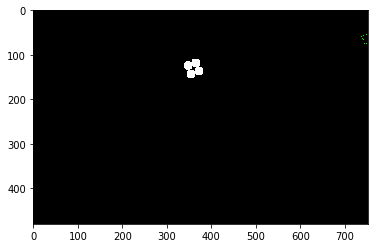

In [69]:
for i in range(len(contoursVerm)):

    

    epsilon = 0.1*cv.arcLength(contoursVerm[i],True)
    approx = cv.approxPolyDP(contoursVerm[i],epsilon,True)

    img = imgContVerm.copy()

    if(len(approx) < 4):
        continue

    if not cv.isContourConvex(approx):
            continue

    for point in approx:
        cv.circle(img, (point[0][0], point[0][1]), 10, (255,255,255), -1)

    plt.imshow(img)
    plt.show()

In [7]:
def procuraQuadrado(mascara):
    kernel = np.ones((5,5),np.uint8)
    
    bordas = cv.Canny(mascara, 100, 500, kernel)
    contours,hierarchy = cv.findContours(bordas, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    quadrados = []

    for i in range(len(contours)):
        epsilon = 0.1*cv.arcLength(contours[i],True)
        approx = cv.approxPolyDP(contours[i],epsilon,True)

        if(len(approx) < 4):
            continue

        if not cv.isContourConvex(approx):
            continue

        quadrado = []

        for point in approx:
            quadrado.append([point[0][0], point[0][1]])
        
        quadrados.append(quadrado)

    quadrados = np.array(quadrados)

    i = 0

    while(len(quadrados)-2 >= i):
        if np.linalg.norm(quadrados[i+1][0]-quadrados[i][0]) < 5:
            quadrados = np.delete(quadrados, i, 0)
            
        i+=1
    
    return quadrados

In [8]:
def imprimeQuadrado(quadrado, img):
    imgDraw = img.copy()
    
    for point in quadrado:
        cv.circle(imgDraw, (point[0], point[1]), 10, (255,255,255), -1)

    plt.imshow(imgDraw)
    plt.show()

def imprimeTodosQuadrados(quadrados, img):
    for quad in quadrados:
        imprimeQuadrado(quad, img)

In [9]:
quadVerde = procuraQuadrado(masc_verde)
quadVerm = procuraQuadrado(masc_verm)

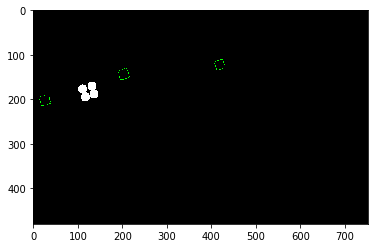

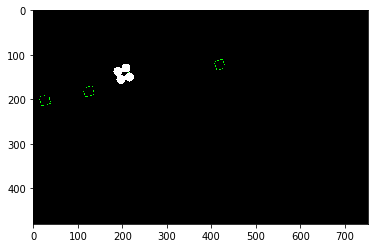

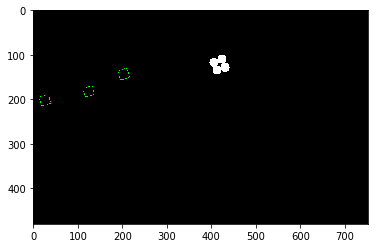

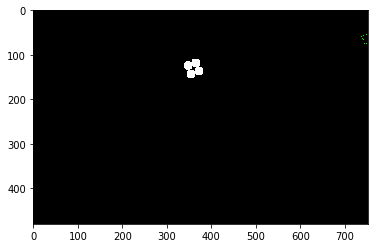

In [47]:
imprimeTodosQuadrados(quadVerde, imgContVerde)
imprimeTodosQuadrados(quadVerm, imgContVerm)

In [10]:
pontoReal = np.array([[2.5e-2, -2.5e-2, 0],
                    [2.5e-2, 2.5e-2, 0],
                    [-2.5e-2, 2.5e-2, 0],
                    [-2.5e-2, -2.5e-2, 0]], dtype=np.float32)
                    
K = np.array([[215.6810060961547, 0.0, 376.5], [0.0, 215.6810060961547, 240.5], [0.0, 0.0, 1.0]],dtype=np.float32)

In [11]:
def inverteTransformacao(R, t):
    RInverso = np.transpose(R)

    tInverso  = - np.matmul(RInverso, t)

    return RInverso, tInverso

def estimaPoseSensor(quad):


    a, RCamObj, tCamObj, _ = cv.solvePnPRansac(pontoReal,quad , K, np.zeros((5,1)))

    tCamObj = tCamObj.ravel()

    RCamObj, _ = cv.Rodrigues(RCamObj)

    RObjCamera, tObjCamera = inverteTransformacao(RCamObj, tCamObj)

    return RObjCamera, tObjCamera

In [12]:
RVerde = []
tVerde = []

quadVerde = quadVerde.astype(np.float32)

for quad in quadVerde:
    R, t = estimaPoseSensor(quad)
    RVerde.append(R)
    tVerde.append(t)

RVerde = np.array(RVerde, dtype=np.float32)
tVerde = np.array(tVerde, dtype=np.float32)

RVerm = []
tVerm = []

quadVerm = quadVerm.astype(np.float32)

for quad in quadVerm:
    R, t = estimaPoseSensor(quad)
    RVerm.append(R)
    tVerm.append(t)

RVerm = np.array(RVerm, dtype=np.float32)
tVerm = np.array(tVerm, dtype=np.float32)

In [91]:
RObjWordl = np.matmul(RDroneWorld, RVerm[0])
tObjWorld = tDroneWorld+np.matmul(RDroneWorld, tVerm[0])

tObjWorld

array([ 2.93777773, -2.71864894,  0.44160527])

In [16]:
np.linalg.norm(tVerde[1]-tVerde[2])

0.57940841

In [17]:
for i in range(len(tVerde)-1):
    print(np.linalg.norm(tVerde[i]-tVerde[i+1]))


0.236492
0.579408
